# Discretization and clustering

We'll discretize trajectories using the [H3 library](https://uber.github.io/h3-py/intro.html) and then use a metric that is designed to compare discrete sequences (like strings) in the clustering.

## Get data

We'll download one file from https://zenodo.org/record/4650317.
This only needs to be executed once.

In [1]:
# !mkdir -p data/
# !curl \
#     -o data/trajectories_nostokes_subset_10000.csv.gz \
#     https://zenodo.org/record/4650317/files/trajectories_nostokes_subset_10000.csv.gz
# !gunzip -f -v data/trajectories_nostokes_subset_10000.csv.gz

## Prepare env

In [2]:
import numpy as np
import pandas as pd

## Parameters

In [3]:
num_traj = 500
random_trajs = False
random_seed = 1234
data_path = "data/trajectories_nostokes_subset_10000.csv"

In [4]:
np.random.seed(random_seed)  # reproducibility!

## Load data and extract a few trajectories

In [5]:
def load_and_subset_trajectories(
    file_name, num_traj=300, use_random=False
):
    """Load data file and extract a number of trajectories.
    
    Parameters
    ----------
    file_name: str or Path
        File to open.
    num_traj: int
        Number of trajectories to load
    use_random: book
        If true, choose num_traj trajectories at random.
        If false, choose first num_traj trajectories.
    
    Returns
    -------
    pandas.DataFrame
        Trajectorie

    """

    df = pd.read_csv(file_name)

    # the whole dataset is too big to open here.
    if use_random:
        # Let's subset to fewer random trajectories:
        random_trajs = np.random.choice(
            np.unique(df["traj"]), num_traj, replace=False
        )
        traj_mask = df["traj"].apply(lambda x: x in random_trajs)
    else:
        # Let's use the first N trajectories
        first_n_trajs = np.unique(df["traj"])[:num_traj]
        traj_mask = df["traj"].apply(lambda x: x in first_n_trajs)
    
    df = df[traj_mask]
    
    return df

In [6]:
df = load_and_subset_trajectories(
    data_path,
    num_traj=num_traj,
    use_random=random_trajs,
)

df["time"] = pd.to_datetime(df["time"])

# df = df[["traj", "obs", "lat", "lon"]]

df = df.set_index(["traj", "obs"])

df = df.sort_index(axis=0, level=0)

display(df)

MPA    distance  land        lat       lon       temp  \
traj obs                                                          
0    0    1.0    0.000000   0.0  43.310062  5.194578  13.392999   
     1    1.0    0.188183   0.0  43.308975  5.196365  13.394862   
     2    1.0    0.367667   0.0  43.307938  5.198070  13.396412   
     3    1.0    0.539166   0.0  43.306946  5.199698  13.397730   
     4    1.0    0.704321   0.0  43.305990  5.201263  13.398852   
...       ...         ...   ...        ...       ...        ...   
499  957  0.0  745.716430   0.0  39.828987  4.950957  16.621582   
     958  0.0  746.195500   0.0  39.826950  4.946003  16.617033   
     959  0.0  746.702500   0.0  39.824640  4.940873  16.613560   
     960  0.0  747.238500   0.0  39.822052  4.935563  16.611376   
     961  0.0  747.284500   0.0  39.821823  4.935113  16.611261   

                        time         z  
traj obs                                
0    0   2017-03-01 00:00:00  1.018237  
     1   2017-03-01 01:00:00  1.018237  
     2   2017-03-01 02:00:00  1.018237  
     3   2017-03-01 03:00:00  1.018237  
     4   2017-03-01 04:00:00  1.018237  
...                      ...       ...  
499  957 2017-04-15 21:00:00  5.464963  
     958 2017-04-15 22:00:00  5.464963  
     959 2017-04-15 23:00:00  5.464963  
     960 2017-04-16 00:00:00  5.464963  
     961 2017-04-16 00:00:00  5.464963  

[481000 rows x 8 columns]

## Have a look

<AxesSubplot:xlabel='lon', ylabel='lat'>

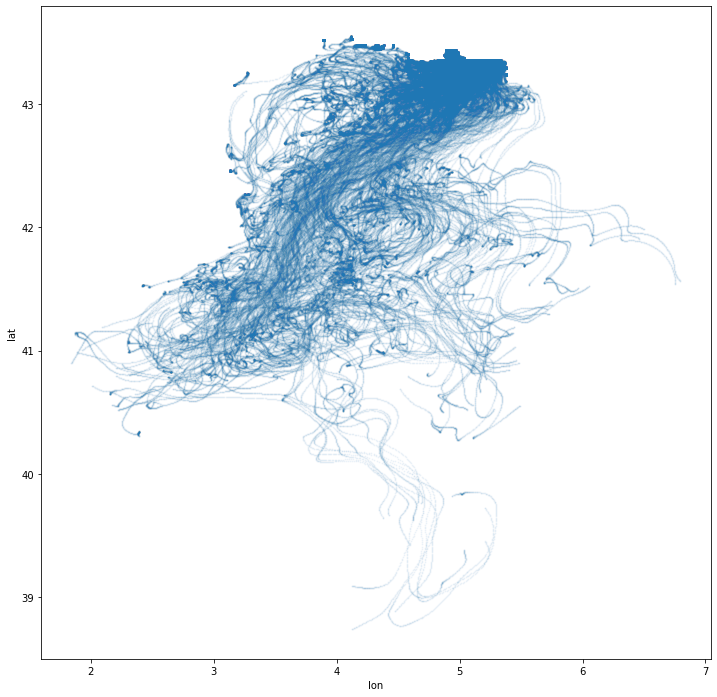

In [7]:
df.plot.scatter(x="lon", y="lat", s=1, alpha=0.05, figsize=(12, 12))

## Discretize with H3

In [8]:
import h3
import h3.api.numpy_int
import h3.api.basic_str

In [9]:
def df_to_h3(df, resolution=0):
    """Convert series of lat and lon to series of h3s.
    
    Parameters
    ----------
    df: pandas.Dataframe
        Has columns "lat" and "lon".
    resolution: int
        H3 resolution. Default to 8 corresponding to approx. 500 meters.
        
    Returns
    -------
    pandas.Series
        h3s
    """
    return df.apply(
        lambda rw: h3.geo_to_h3(
            lat=rw["lat"], lng=rw["lon"],
            resolution=resolution,
        ),
        axis=1,
    ).to_frame(name="h3")

In [10]:
%%time

df["h3"] = df_to_h3(df)

CPU times: user 6.19 s, sys: 148 ms, total: 6.34 s
Wall time: 6.34 s


In [11]:
def _get_unique_index(trajectory):
    def _collapse(sequence):
        last = None
        for n, element in enumerate(sequence):
            if element != last:
                yield n
            last = element
    return trajectory.index[list(_collapse(trajectory))]

In [12]:
def _collapse_h3_traj(traj):
    collapsed_ind = _get_unique_index(traj["h3"])
    return traj.loc[collapsed_ind]

In [13]:
def collapse_h3s_df(df):
    """Collapse identical consecutive H3s in each trajectory in df.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Input dataframe having a `MultiIndex` ('traj', 'obs').
    
    Returns
    -------
    pandas.DataFrame
        With the same trajectory index, but collapsed `obs` steps.
    
    """
    traj_dfs = (_df for _traj, _df in df.groupby("traj"))
    collapsed_traj_dfs = map(_collapse_h3_traj, traj_dfs)
    return pd.concat(collapsed_traj_dfs)

In [14]:
%time display(collapse_h3s_df(df_to_h3(df, resolution=6)))

h3
traj obs                 
0    0    863968107ffffff
     15   86396811fffffff
     68   863968107ffffff
     96   86396811fffffff
     132  863968027ffffff
...                   ...
499  859  86394e6afffffff
     870  86394e6a7ffffff
     886  86394e79fffffff
     920  86395db6fffffff
     957  86395db67ffffff

[32411 rows x 1 columns]

CPU times: user 6.6 s, sys: 88 ms, total: 6.69 s
Wall time: 6.69 s


## Remove very short trajectories

In [15]:
def remove_short_trajs(df, cutoff=0):
    """Remove short trajectories at the given resolution.
    
    Parameters
    ----------
    df: pandas.DataFrame
        First index level counts trajectories.
    cutoff: int
        Defaults to 0, meaning no trajectories will be discarded.
        
    Returns
    -------
    pandas.DataFrame
        Contains only long trajectories.

    """
    number_points = pd.Series(
        [len(df.loc[traj]) for traj in df.index.levels[0]],
        index=df.index.levels[0]
    )

    long_trajectories = number_points.index[(number_points >= cutoff)]
    
    if len(long_trajectories) > 0:
        df_ret = pd.concat(
            (df.loc[trj] for trj in long_trajectories),
            keys=long_trajectories
        )
    else:  # return empty if no traj remains
        df_ret = pd.DataFrame(data=None, columns=df.columns, index=df.index).iloc[:0]
    
    return df_ret

In [16]:
%time remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=7)), cutoff=4)

CPU times: user 7.02 s, sys: 72.2 ms, total: 7.09 s
Wall time: 7.09 s


h3
traj obs                 
0    0    873968115ffffff
     2    873968102ffffff
     15   87396811cffffff
     33   873968118ffffff
     60   87396811cffffff
...                   ...
499  899  87394e79affffff
     928  87395db6dffffff
     949  87395db6cffffff
     956  87395db61ffffff
     960  87395db63ffffff

[82615 rows x 1 columns]

## Distance metric

In [17]:
import editdistance

In [18]:
def traj_editdist(traj_0, traj_1):
    return editdistance.eval(list(traj_0["h3"]), list(traj_1["h3"]))

In [19]:
traj_0_index = df.index.levels[0][0]
traj_1_index = df.index.levels[0][2]

In [20]:
traj0 = df.loc[traj_0_index]
traj1 = df.loc[traj_1_index]

%time traj_editdist(traj0, traj1)

CPU times: user 4.38 ms, sys: 15 µs, total: 4.39 ms
Wall time: 4.31 ms


108

In [21]:
_df = collapse_h3s_df(df)
traj0 = _df.loc[traj_0_index]
traj1 = _df.loc[traj_1_index]

%time traj_editdist(traj0, traj1)

CPU times: user 185 µs, sys: 7 µs, total: 192 µs
Wall time: 200 µs


5

## Clustering

In [22]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances

### Data and metric prep

In [23]:
def wrapped_dist(x, y, df=None, **kwargs):
    i, j = int(x[0]), int(y[0])
    tind0 = df.index.levels[0][i]
    tind1 = df.index.levels[0][j]
    t0 = df.loc[tind0]
    t1 = df.loc[tind1]
    norm = max(len(t0), len(t1))
    return traj_editdist(t0, t1) / norm

In [24]:
from functools import partial

In [25]:
def get_edit_distance_matrix(df):
    X = np.arange(len(df.index.levels[0])).reshape(-1, 1)
    return pairwise_distances(X, metric=partial(wrapped_dist, df=df))

### Clustering

In [26]:
%%time

_df = remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=3)), cutoff=2)
# _df = _df.reindex()
print(len(_df.index.levels[0]))

425
CPU times: user 6.54 s, sys: 95.9 ms, total: 6.63 s
Wall time: 6.63 s


In [27]:
%%time

dist = get_edit_distance_matrix(_df)

CPU times: user 34.2 s, sys: 574 ms, total: 34.7 s
Wall time: 34.1 s


In [28]:
dist.shape

(425, 425)

In [29]:
import xarray as xr

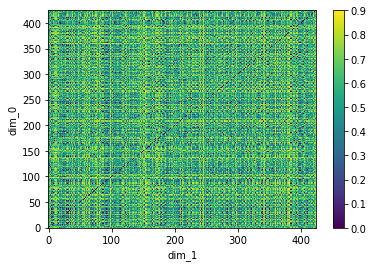

In [30]:
xr.DataArray(dist).plot();

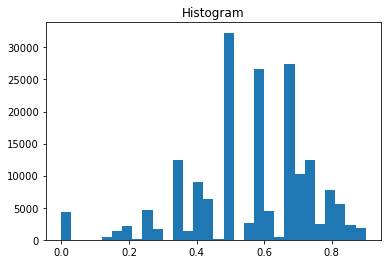

In [31]:
xr.DataArray(dist).plot.hist(bins=30);

In [32]:
%%time
# ids = OPTICS(metric="precomputed", max_eps=0.6).fit_predict(dist)
ids = AgglomerativeClustering(affinity="precomputed", linkage="complete", distance_threshold=0.6, n_clusters=None).fit_predict(dist)
# ids = DBSCAN(metric="precomputed", eps=0.3).fit_predict(dist)

CPU times: user 13.1 ms, sys: 33 µs, total: 13.1 ms
Wall time: 10.5 ms


<AxesSubplot:ylabel='Frequency'>

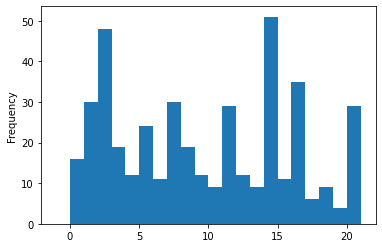

In [33]:
pd.Series(ids).plot.hist(bins=np.arange(-1, ids.max() + 1))

In [34]:
import numpy as np

In [35]:
from matplotlib import pyplot as plt

In [36]:
from shapely.geometry import Polygon

import geopandas

In [37]:
hexs = np.unique(_df["h3"])

In [38]:
polygonise = lambda hex_id: Polygon(
    h3.h3_to_geo_boundary(
        hex_id, geo_json=True)
)

all_polys = geopandas.GeoSeries(
    list(map(polygonise, hexs)), 
    index=hexs, 
    crs="EPSG:4326",    
)

0 0 108
1 1 200
2 2 239
3 3 93
4 4 73
5 5 162
6 6 66
7 7 155
8 8 57
9 9 60
10 10 45
11 11 132
12 12 48
13 13 89
14 14 111
15 15 84
16 16 114
17 17 43
18 18 73
19 19 41
20 20 20
21 21 83


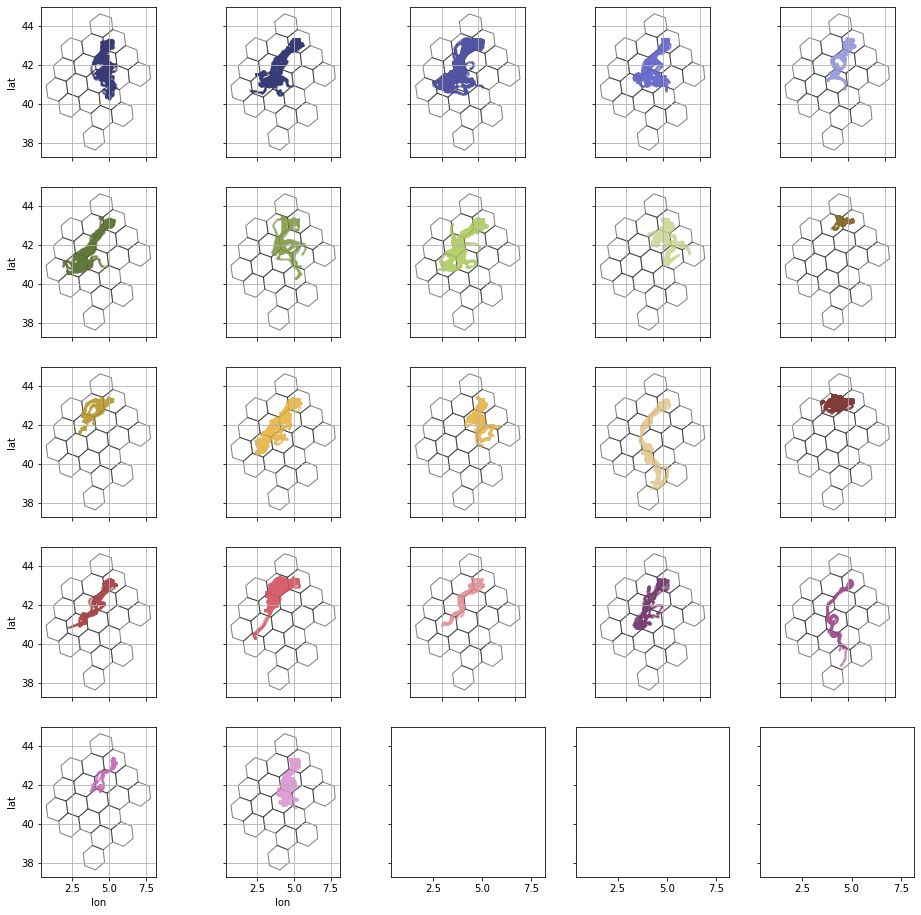

In [39]:
# _df = remove_short_trajs(collapse_h3s_df(df_to_h3(df, resolution=5)), cutoff=10)
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(16, 16))
for (n, _id), _ax in zip(enumerate(np.unique(ids)), ax.flatten()):
    print(n, _id, len(_df.loc[_df.index.levels[0][ids==_id]]))
    _trajs = _df.index.levels[0][ids==_id]
    all_polys.plot(alpha=0.5, color="none", edgecolor='black', figsize=(9, 9), ax=_ax)
    df.loc[_trajs].plot.scatter(x="lon", y="lat", s=2, alpha=0.05, ax=_ax, color=plt.cm.tab20b(n / (ids.max() + 1)))
    _ax.grid();